# blender implicit with search

## autoreload

In [1]:
%load_ext autoreload
%autoreload 2

## dir setup

In [2]:
from dotenv import load_dotenv, find_dotenv
import os

this_file_path = os.path.dirname(os.path.abspath("__file__"))
# if script (not notebook)...
# project_dir = os.path.join(os.path.dirname(__file__), os.pardir)

# project directory
project_dir = os.path.join(this_file_path, os.pardir)

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

True

In [3]:
raw_data_dir = os.path.join(project_dir, os.environ.get("RAW_DATA_DIR"))
processed_data_dir = os.path.join(project_dir, os.environ.get("PROCESSED_DATA_DIR"))
interim_data_dir = os.path.join(project_dir, os.environ.get("INTERIM_DATA_DIR"))
wordvecs_data_dir = os.path.join(project_dir, os.environ.get("WORDVECS_DATA_DIR"))
figures_dir = os.path.join(project_dir, os.environ.get("FIGURES_DIR"))
reports_dir = os.path.join(project_dir, os.environ.get("REPORTS_DIR"))
cv_dir = os.path.join(project_dir, os.environ.get("CV_DIR"))
models_dir = os.path.join(project_dir, os.environ.get("MODELS_DIR"))

In [4]:
TEST_OFFSET = int(os.environ.get("TEST_OFFSET"))
TOTAL_TEST_SEQS = int(os.environ.get("TOTAL_TEST_SEQS"))

## imports

In [5]:
import numpy as np
from datetime import datetime

In [6]:
import pandas as pd
# pd.set_option('max_rows', None)
# pd.set_option('max_columns', None)
# pd.options.mode.chained_assignment = None  # default='warn'

In [7]:
from tqdm import tqdm
tqdm.pandas()

/Users/hitoshinagano/.virtualenvs/tensorflow2/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [8]:
# import scipy.sparse as sparse
# import implicit

# from sklearn.metrics import ndcg_score

# from sklearn.model_selection import ParameterGrid

# import mlflow

import pickle

## project imports

In [9]:
import sys
sys.path.insert(0, '..')

In [10]:
from src.features import *
from src.models import *

#### reading pred 6 (implicit preds)

In [63]:
pred_6_fn = 'pred_6_with_topscore.csv'
pred_6_fp = os.path.join(reports_dir, pred_6_fn)
pred_6 = pd.read_csv(pred_6_fp, header = None)

In [64]:
pred_6.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1572239,1194894,1717880,1300048,1006988,341077,398330,1856280,1326593,794338,0.923182
1,943786,849692,1676401,1056120,416551,937449,1180937,80018,495680,1184491,0.980219
2,731397,1986443,1706245,167018,283306,722653,438010,2015578,1162105,1322369,0.361114
3,1398419,1465133,1114720,1983750,702406,19910,1784740,63682,8478,819461,0.406496
4,1950320,1412311,553430,758537,1683191,1094798,769817,236682,6328,74407,0.944184


In [47]:
pred_6 = pred_6.reindex(index = range(TOTAL_TEST_SEQS))

<AxesSubplot:>

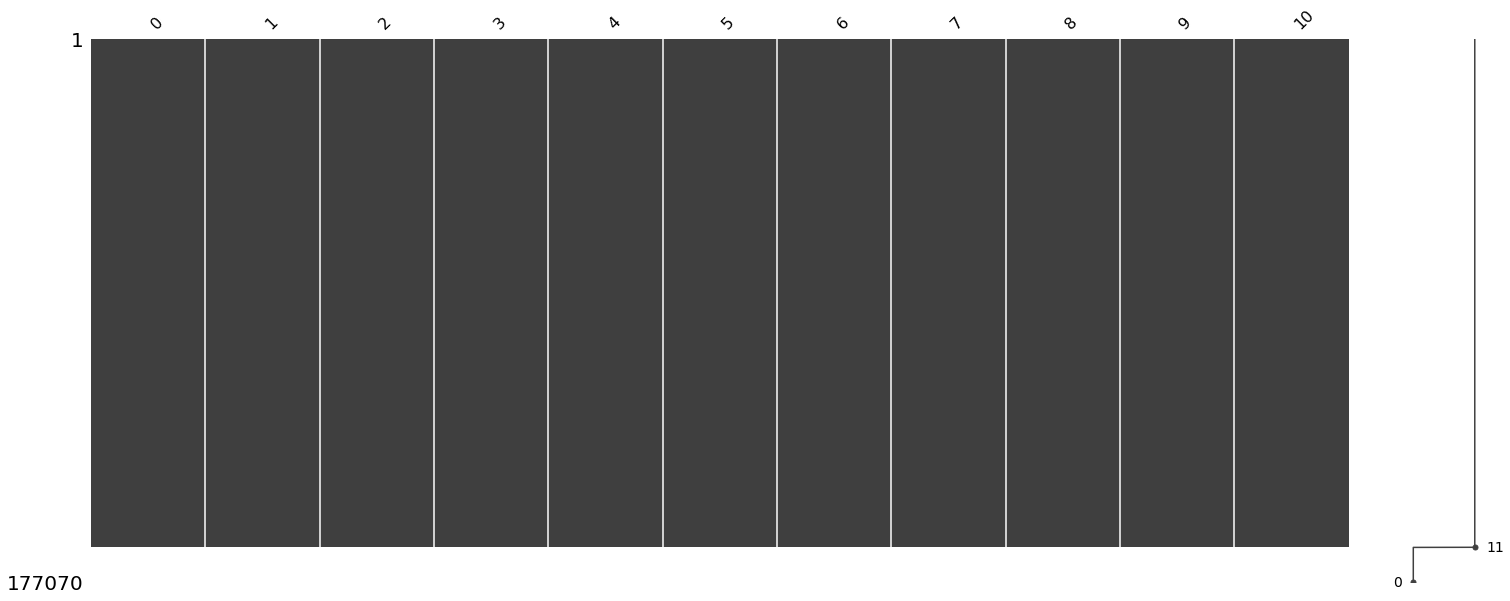

In [55]:
import missingno as mn
mn.matrix(pred_6)

### using actual submitted csv
pred_6_with_topscore.csv is missing rows...

In [11]:
pred_6_fn = 'pred_6_implicit.csv'
pred_6_fp = os.path.join(reports_dir, pred_6_fn)
pred_6_submitted = pd.read_csv(pred_6_fp, header = None)

In [12]:
pred_6_submitted[pred_6_submitted.duplicated(keep = False)]

,0,1,2,3,4,5,6,7,8,9
3,1587422,1803710,10243,548905,1906937,716822,1361154,1716388,859574,725371
7,1587422,1803710,10243,548905,1906937,716822,1361154,1716388,859574,725371
14,1587422,1803710,10243,548905,1906937,716822,1361154,1716388,859574,725371
16,23903,624249,602671,1076204,1805356,1251230,1656985,184980,2022473,344295
26,2072175,1102234,1362211,485245,1450809,2100037,2076362,1294434,1363977,531471
...,...,...,...,...,...,...,...,...,...,...
177039,23903,624249,602671,1076204,1251230,1805356,184980,1656985,2022473,344295
177045,1030770,646288,211927,1022423,1577307,1452260,372639,1580759,1433118,1315888
177054,356153,1554936,804903,389388,645773,527577,701247,1268709,1551100,462003
177058,1587422,1803710,10243,548905,1906937,716822,1361154,1716388,859574,725371


In [13]:
pred_6_submitted['no_implicit_pred'] = (pred_6_submitted[0] == 1587422) & (pred_6_submitted[1] == 1803710) & (pred_6_submitted[9] == 725371)

In [14]:
pred_6_submitted = pred_6_submitted[~pred_6_submitted.no_implicit_pred].copy()

In [15]:
pred_6_submitted.drop('no_implicit_pred', axis = 1, inplace = True)

In [16]:
# pred_6 = pred_6.reindex(index = range(TOTAL_TEST_SEQS))

In [18]:
pred_6_submitted

,0,1,2,3,4,5,6,7,8,9
0,1572239,1194894,1717880,1300048,1006988,341077,398330,1856280,1326593,794338
1,943786,849692,1676401,1056120,416551,937449,1180937,80018,495680,1184491
2,731397,1986443,1706245,167018,283306,722653,438010,2015578,1162105,1322369
4,1398419,1465133,1114720,1983750,702406,19910,1784740,63682,8478,819461
5,1950320,1412311,553430,758537,1683191,1094798,769817,236682,6328,74407
...,...,...,...,...,...,...,...,...,...,...
177065,23903,624249,602671,1076204,1805356,1251230,1656985,184980,2022473,763171
177066,69447,716822,1328443,161963,1651522,1328997,780726,717106,1859462,459697
177067,1550304,1426798,273237,1395589,2033823,460028,1839331,1576126,289602,136713
177068,1116998,1197876,517435,1396359,273725,1803169,662857,1575734,1565340,745928


In [19]:
pt_search_recs_fn = 'pt_search_recs.pkl'
pt_search_recs_fp = os.path.join(interim_data_dir, pt_search_recs_fn)
pt_search_recs = pd.read_pickle(pt_search_recs_fp)

# es_search_recs_fn = 'es_search_recs.pkl'
# es_search_recs_fp = os.path.join(interim_data_dir, es_search_recs_fn)
# es_search_recs = pd.read_pickle(es_search_recs_fp)

In [20]:
pt_search_recs = pt_search_recs.applymap(lambda x: x[0]).T
# es_search_recs = es_search_recs.applymap(lambda x: x[0]).T

In [21]:
# search_recs = pd.concat([pt_search_recs, es_search_recs])
search_recs = pt_search_recs

In [22]:
search_recs.sort_index(inplace = True)

In [23]:
search_recs

,0,1,2,3,4,5,6,7,8,9
3,814644,1892910,1929037,337033,976976,1495252,541684,448188,816584,1380283
7,1082150,1383352,228294,280001,905962,906435,520318,830606,1501646,63665
14,1851419,148757,1220316,1182308,1274709,511711,311980,2029715,635704,1005775
90,109814,1169893,218698,1885984,1540766,512315,916762,502870,84712,1726133
98,1429023,655663,174389,1589919,1147203,1332181,1231500,1760346,1313508,1476421
...,...,...,...,...,...,...,...,...,...,...
177022,829923,1793967,485717,1692963,760768,1685125,1030062,1487578,1311781,925639
177024,131921,90072,423989,791587,1042837,736983,1816259,1603854,630862,1478801
177028,34681,1638469,1313392,154859,656288,371714,1230747,774374,547697,763433
177037,245362,1541195,260797,852531,1473056,195149,2045233,1624469,634569,1091661


In [24]:
replaced_idx = list(set(search_recs.index) & set(pred_6_submitted.index))

In [25]:
len(replaced_idx)

0

### merging both prediction dataframes - dropping from implicit if duplicated

In [26]:
pred_7 = pd.concat([search_recs, pred_6_submitted])

In [29]:
pred_7.sort_index(inplace = True)

In [30]:
pred_7

,0,1,2,3,4,5,6,7,8,9
0,1572239,1194894,1717880,1300048,1006988,341077,398330,1856280,1326593,794338
1,943786,849692,1676401,1056120,416551,937449,1180937,80018,495680,1184491
2,731397,1986443,1706245,167018,283306,722653,438010,2015578,1162105,1322369
3,814644,1892910,1929037,337033,976976,1495252,541684,448188,816584,1380283
4,1398419,1465133,1114720,1983750,702406,19910,1784740,63682,8478,819461
...,...,...,...,...,...,...,...,...,...,...
177065,23903,624249,602671,1076204,1805356,1251230,1656985,184980,2022473,763171
177066,69447,716822,1328443,161963,1651522,1328997,780726,717106,1859462,459697
177067,1550304,1426798,273237,1395589,2033823,460028,1839331,1576126,289602,136713
177068,1116998,1197876,517435,1396359,273725,1803169,662857,1575734,1565340,745928


In [32]:
pred_7_fn = 'pred_7_implicit_search_embs_noviews.csv'
pred_7_fp = os.path.join(reports_dir, pred_7_fn)
pred_7.to_csv(pred_7_fp, header = None, index = None)

#### saving implicit ALS model (pkl)
all latent factors included in model

#### saving item factors (txt)
vector ordered by event_info_id (see event_info_map for a map)

#### saving event_info_map (pkl)
need to convert event_info (original from meli) into event_info_id (used in implicit)

#### testing loading implicit ALS model